# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

  Running setup.py bdist_wheel for pyvirtualdisplay ... done
  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0fd40f54446dde99da
  Running setup.py bdist_wheel for EasyProcess ... done
  Stored in directory: /root/.cache/pip/wheels/41/22/19/af15ef6264c58b625a82641ed7483ad05e258fbd8925505227
Successfully built pyvirtualdisplay EasyProcess
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 2. Define the Architecture of the Policy

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # so here act not only runs NN forward to get probability distribution of taking each action 
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        # but also samples that ditribution to pick an action, we're using Torch.distributions Categorical to help
        action = m.sample()
        return action.item(), m.log_prob(action)  #we return not just selected action, but alos log_prob of that action (for REINFORCE)

observation space: Box(4,)
action space: Discrete(2)


In [4]:
s = env.reset()


In [10]:
torch.from_numpy(s).float().shape

torch.Size([4])

In [11]:
torch.from_numpy(s).float().unsqueeze(0).shape

torch.Size([1, 4])

In [13]:
torch.from_numpy(s).float().unsqueeze(0)

tensor(1.00000e-02 *
       [[-4.4564,  4.6539,  1.3269, -2.0998]])

In [12]:
torch.from_numpy(s).float().unsqueeze(1).shape

torch.Size([4, 1])

## Reinforce deconstructed

In [14]:
policy = Policy().to(device)

In [23]:
probs = policy.forward(torch.from_numpy(s).float().unsqueeze(0)).cpu()

## REINFORCE implementation in Torch with Torch.Distributions

https://pytorch.org/docs/stable/distributions.html

explains well how Policy.act above works

```python
def act(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = self.forward(state).cpu()
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)
```
When the probability density function is differentiable with respect to its parameters, we only need sample() and log_prob() to implement REINFORCE:

```math 
Δθ = α*r* ∂log p(a∣πθ(s))/ ∂θ 

```
 
where  θ are the parameters, α is the learning rate, r is the reward and p(a∣πθ(s)) is the probability of taking action a in state s given policy πθ.
(..) 
In practice we would sample an action from the output of a network, apply this action in an environment, and then use log_prob to construct an equivalent loss function. Note that we use a negative because optimizers use gradient descent, whilst the rule above assumes gradient ascent. With a categorical policy, the code for implementing REINFORCE would be as follows:


```python
probs = policy_network(state)
# Note that this is equivalent to what used to be called multinomial
m = Categorical(probs)
action = m.sample()
next_state, reward = env.step(action)
## ESSENCE of REINFORCE, we construct loss function by multiplying log_probs(action) * reward
loss = -m.log_prob(action) * reward  
loss.backward()

```



In [53]:
# constructing Torch distributions object for that prob distributions
m = Categorical(probs)
# sample an action using that distribution
action = m.sample()
print("Now returning selected action={}, log_probability of that action={}, probability_of_that action={}".format(action.item(), m.log_prob(action).item(), torch.exp(m.log_prob(action)).item()))
action.item(), m.log_prob(action), torch.exp(m.log_prob(action))

Now returning selected action=0, log_probability of that action=-0.8903422951698303, probability_of_that action=0.4105152189731598


(0, tensor([-0.8903]), tensor([ 0.4105]))

### 3. Train the Agent with REINFORCE

In [62]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # run an episode with current policy and collect trajectories, log_probs and rewards 
        for t in range(max_t):
            action, log_prob = policy.act(state)
            # save log_prob by current policy
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        #calculate sum of discounted rewards
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        # sum up the loss, i.e sum(-log_prob * discounted_rewards)
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        #concat log_prob tensors and sum them
        policy_loss = torch.cat(policy_loss).sum()
        
        # usual Torch stuff
        optimizer.zero_grad()  # zero gradiends
        policy_loss.backward() #  run backward propagation 
        optimizer.step()       # and Adam optimizer step to update policy parameters()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce(n_episodes=3000)

Episode 100	Average Score: 26.57
Episode 200	Average Score: 50.51
Episode 300	Average Score: 68.91
Episode 400	Average Score: 82.06
Episode 500	Average Score: 24.82
Episode 600	Average Score: 41.59
Episode 700	Average Score: 63.36
Episode 800	Average Score: 85.66
Episode 900	Average Score: 49.48
Episode 1000	Average Score: 110.65
Episode 1100	Average Score: 128.13
Episode 1200	Average Score: 102.36
Episode 1300	Average Score: 63.90
Episode 1400	Average Score: 73.78
Episode 1500	Average Score: 107.60
Episode 1600	Average Score: 170.48
Episode 1700	Average Score: 193.49
Episode 1800	Average Score: 162.35
Episode 1900	Average Score: 105.14
Episode 2000	Average Score: 96.91
Episode 2100	Average Score: 73.72
Episode 2200	Average Score: 65.09
Episode 2300	Average Score: 58.95
Episode 2400	Average Score: 46.57
Episode 2500	Average Score: 45.80
Episode 2600	Average Score: 41.45
Episode 2700	Average Score: 43.02
Episode 2800	Average Score: 47.87
Episode 2900	Average Score: 48.62
Episode 3000	Av

In [54]:
?torch.cat

### 4. Plot the Scores

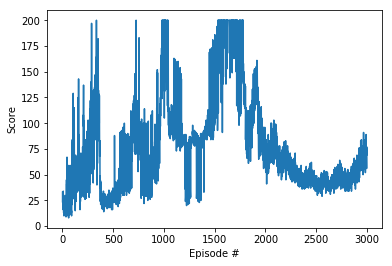

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

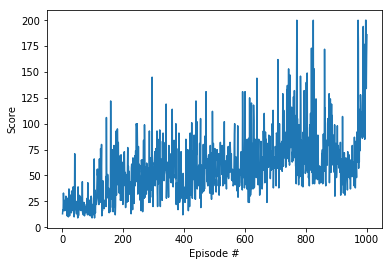

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

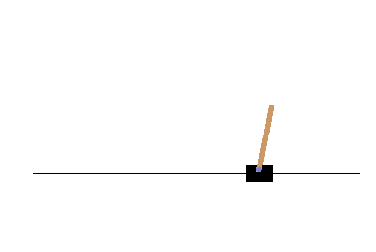

In [57]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()